# Imports

In [1]:
### IMPORTS ### 
import sys

from Func_Floquet_classes import *
from matplotlib import cm
from IPython.display import Math
from sympy.interactive import printing

import seaborn as sns
import pandas as pd

## Personalized plots
from matplotlib.lines import Line2D
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r"\usepackage{bm,amsmath,amsfonts,amssymb,bbold}"
from Func_general import *
# plotParams('paper')

plt.rcParams.update({
    "pgf.texsystem": "lualatex",
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
         r"\usepackage{amssymb}",   
         r"\usepackage{unicode-math}",   # unicode math setup
         r"\setromanfont[Scale=1.04]{Libertinus Serif}",  # serif font via preamble
         r"\setsansfont[Scale=1]{Libertinus Sans}",
         r"\setmonofont[Scale=.89]{Liberation Mono}",
         r"\setmathfont{Libertinus Math}"
    ]),
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "serif"
})

def set_size(width, height=None, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height==None:
        fig_height_in = fig_width_in * golden_ratio
    else:
        fig_height_in = height * inches_per_pt

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

%matplotlib inline

In [2]:
textwidth = 304.44289 #pt
pagewidth = 457.8024 #pt
textheight = 689.0 #pt
palette = sns.color_palette("colorblind6")
palette

# Linear Dirac model
## Static Floquet picture

In [3]:
## Define the Hamiltonian in SymPy form
ham_symbolsLin = sp.symbols("v hbar", real=True) ## definition of the extra symbols, in this case the velocity of the linear term
ham_dict = {str(b): b for b in ham_symbolsLin}
locals().update( ham_dict)

hDirac = Hamiltonian(
    h0_k = hbar* v*sx*k_y - hbar* v*sy*k_x,
    Axt=A_x * sp.sin(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    ham_symbols=ham_symbolsLin)

In [4]:
## Define the Floquet-Fourier Hamiltonian, we let some variables to be modified later
par_var = {'k_x': None, 'k_y': None, 'A_x': None, 'A_y': None}
par_fix = {'v': 1., 'hbar': 1.}
hDiracFF = Hamiltonian_FloquetFourier(hDirac, par_var, par_fix =  par_fix,  N = 40)

## Check the Fourier elements calculated by the SymPy integrals
Math('$Q_0 = {}, Q_1 = {},  Q_2 = {}$'.format(
    printing.default_latex(hDirac.fourier_elements(0)), 
    printing.default_latex(hDirac.fourier_elements(1)), 
    printing.default_latex(hDirac.fourier_elements(2))))

<IPython.core.display.Math object>

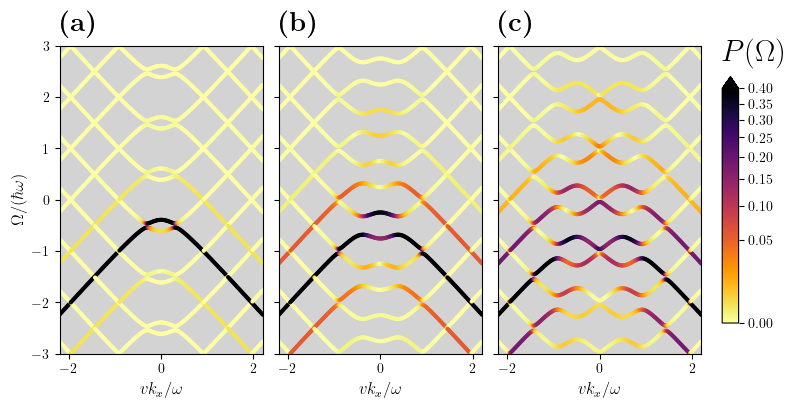

In [6]:
## Figure 1:

momentax = np.linspace(-2.2, 2.2, 201) 
Alist = [0.1, 0.5, 1.]

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)
for ax, Aval, cbar in zip(axs, Alist, [False, False, True]):
    par = {'k_y': 0.4, 'A_x': Aval, 'A_y': 0.}
    obs = ObservablesFF(hDiracFF, 'k_x', momentax, params = par)
    out = obs.photoelAmpPlot(ax = ax, Nmax=6, cbar=cbar, fig = fig, axs = axs, vmax = 0.4)
[ax.set(ylabel = None) for ax in axs[1:]]
axs[0].set(ylabel = r'$\Omega/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
out[1].ax.set_title(r'', fontsize=18, y=1.2, pad=-14)
out[1].ax.set_title(r'$P(\Omega)$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
# fig.savefig(folder0+'/DOS_DiracLinDir.pdf', bbox_inches='tight')

## Floquet t-t' formalism

In [5]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

par_fix = {'v':1., 'T_p' : 1.}
params_env = {'mu_sp' : None, 'tau_sp' : None, 'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.sin(2 * sp.pi / T_p * t_sp),
    Vyt= sp.sin(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) ## N is the number of Fourier replicas considered.


In [6]:
## Data for Figure 2 (a)

Axs = [1.,2.,3.,4.,5.]
psi0band, T = 0, 1 #fixed period T = 1 and band index of the initial state
ts_2a = np.linspace(1e-6, 6 * T, 4000) ## Avoid the singularity at t = 0

solverL_2a = []
ctL_2a = []
for Ax in Axs:
    params_env = {'mu_sp' : 3., 'tau_sp' : 1. , 'A_x': Ax, 'A_y':0, 'A_z': 0}
    params_ham = {'k_x' : 0.1, 'k_y' : 0.0,}
    solverL_2a.append(IFS_solver(hDirac_pulse, ts_2a, params_env, params_ham, Nmax = 12))
    ct, psitsol = solverL_2a[-1].c_t(psi0band=psi0band, tend=5.99, psi_t=True)   
    ctL_2a.append(ct)

State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]


In [7]:
## Data for Figure 2 (b)

taus = [0.8, 1., 1.2]
ts_2b = np.linspace(0, 7.5 * T, 5000) + 1e-6

solverL_2b = []
ctL_2b = []
for tau in taus:
    params_env = {'mu_sp': 4., 'tau_sp': tau, 'A_x': 5., 'A_y': 0, 'A_z': 0}
    params_ham = {'k_x': 0.1, 'k_y': 0.0, }
    solverL_2b.append(IFS_solver(hDirac_pulse, ts_2b, params_env, params_ham, Nmax=14))
for solver in (solverL_2b):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=7, psi_t=True)
    ctL_2b.append(ct)

State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]


In [8]:
## Save the data for Figure 2 
indexCbase_2a = solverL_2a[0].indexCbase
tagvec_2a  = solverL_2a[0].tag_fqlevels()
indexCbase_2b = solverL_2b[0].indexCbase
tagvec_2b  = solverL_2b[0].tag_fqlevels()
np.savez(folder0+'/fig_DiracLin_calphaData', 
         indexCbase_2a = indexCbase_2a, indexCbase_2b = indexCbase_2b, 
         tagvec_2a = tagvec_2a, tagvec_2b=tagvec_2b, ctL_2a = ctL_2a, ctL_2b = ctL_2b, 
         taus = taus, Axs = Axs, ts_2a = ts_2a, ts_2b = ts_2b) 

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3912435/71811157.py:19: SyntaxWarning: invalid escape sequence '\p'
  lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
/tmp/ipykernel_3912435/71811157.py:19: SyntaxWarning: invalid escape sequence '\p'
  lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
/tmp/ipykernel_3912435/71811157.py:21: SyntaxWarning: invalid escape sequence '\p'
  lab_lines2 = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$', '$ (0, \pm 3)$']
/tmp/ipykernel_3912435/71811157.py:21: SyntaxWarn

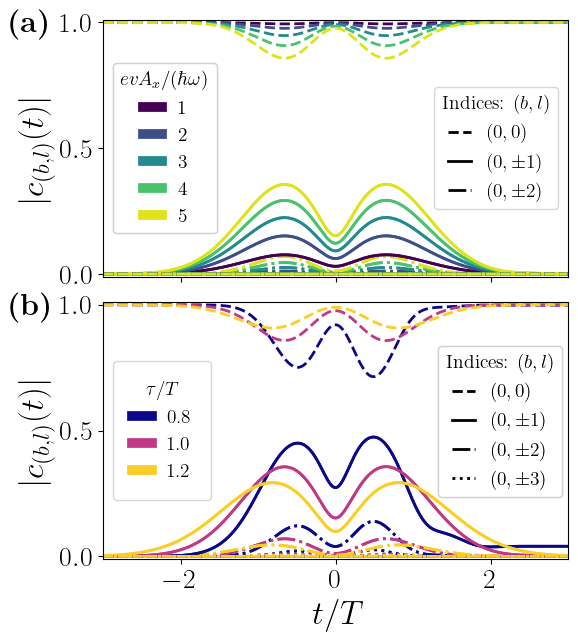

In [9]:
## Figure 2

linedict = {'0': '--', '1': '-', '2':'-.', '3': ':'}
def linestyle(m):
    if m==0:
        return '--'
    elif np.abs(m) == 1:
        return '-'
    elif np.abs(m) == 2:
        return '-.'
    else:
        return ':'
    
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,7), sharey = True, sharex = True )
plt.subplots_adjust(hspace=0.1)

cols = cm.viridis(np.linspace(0, 0.95, len(Axs)))
lines = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in list(linedict.values())[:-1]]
lab_lines = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$']
lines2 = [Line2D([0], [0], color='k', linewidth=2, linestyle=ls)  for ls in list(linedict.values())]
lab_lines2 = ['$(0,0)$', '$(0,\pm 1)$', '$ (0, \pm 2)$', '$ (0, \pm 3)$']
squaresAs = [Line2D([0], [0], color=c, linewidth=7)  for c in cols]
lab_squaresAs = [int(i) for i in Axs]


for ct, color in zip(ctL_2a, cols):
    for cti, i  in enumerate(indexCbase_2a) :
        l, m = tagvec_2a[i] 
        # label = '({},{})'.format(int(l),int(m)) if (np.max(abs(ct[:,cti]))>0.1) else None
        axs[0].plot(ts_2a[:len(ctL_2a[0])]-3, (np.abs(ct[:, cti])), lw=2, c=color, zorder = -np.abs(m), ls = linestyle(m))
lg_lines = axs[0].legend(lines, lab_lines, fontsize = 14, handlelength = 1.2, ncols = 1, loc='center right', title=r"Indices: $(b,l)$",)
lg_lines.get_title().set_fontsize('14')

lg_squares = axs[0].legend(squaresAs, lab_squaresAs, fontsize = 14, handlelength = 1., ncols = 1, loc='center left', title=r"$ev A_x/(\hbar \omega)$",)
lg_squares.get_title().set_fontsize('14')

axs[0].add_artist(lg_lines)
axs[0].add_artist(lg_squares)

cols = cm.plasma(np.linspace(0, 0.9, len(taus)))
squarestaus = [Line2D([0], [0], color=c, linewidth=7)  for c in cols]
lab_squarestaus = taus
for ct, color in zip(ctL_2b, cols):
    for cti, i  in enumerate(indexCbase_2b) :
        l, m = tagvec_2b[i] 
        # label = '({},{})'.format(int(l),int(m)) if (np.max(abs(ct[:,cti]))>0.1) else None
        axs[1].plot(ts_2b[:len(ctL_2b[0])]-4, (np.abs(ct[:, cti])), lw=2, c=color, zorder = -np.abs(m), ls = linestyle(m))

lg_squares = axs[1].legend(squarestaus, lab_squarestaus, fontsize = 14, handlelength = 1., ncols = 1, loc='center left', title=r"$\tau/T$", borderpad =1)
lg_squares.get_title().set_fontsize('14')

lg_lines = axs[1].legend(lines2, lab_lines2, fontsize = 14, handlelength = 1.2, ncols = 1, loc=(0.72, 0.24), title=r"Indices: $(b,l)$",)
lg_lines.get_title().set_fontsize('14')
axs[1].add_artist(lg_lines)
axs[1].add_artist(lg_squares)

axs[1].set(xlim=(-3,3), xlabel = r'$t/T$', ylim = (-0.01, 1.01))
[ax.set(ylabel = r'$|c_{(b,l)}(t)|$') for ax in axs]
createletters(axs, coord=[-0.2, 0.95], SMALL_SIZE=22)
fig.savefig(folder0+'/fig_DiracLin_calpha.pdf', bbox_inches='tight', transparent = True)

State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]


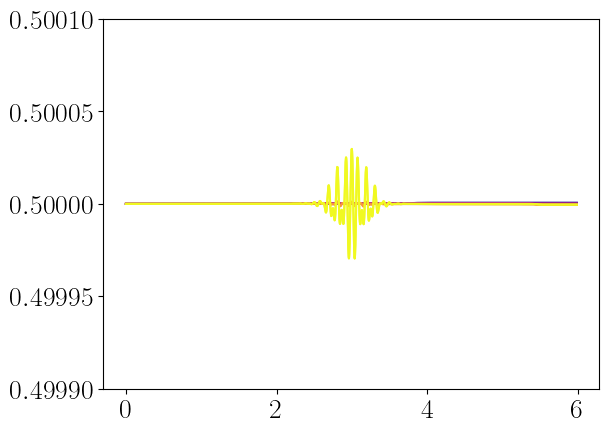

State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]
State at t = 0.00 energy = -0.1000, wf (spinor): [-0.707+0.j     0.   -0.707j]


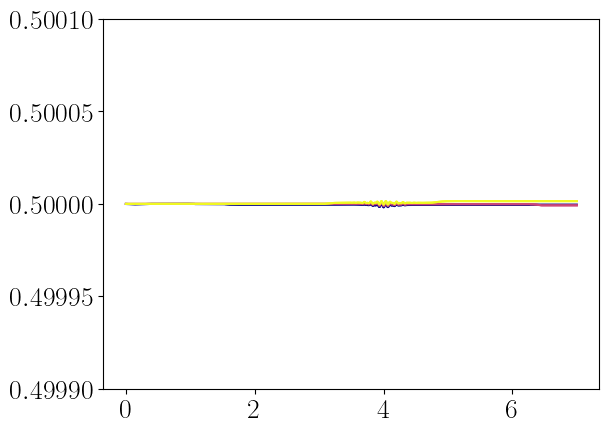

In [11]:
## Check plot
cols = cm.plasma(np.linspace(0, 1, len(solverL_2a)))
for solver, color in zip(solverL_2a, cols):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=5.99, psi_t=True)
    plt.plot(ts_2a[:len(ct)], np.abs(psitsol) ** 2, c=color)
plt.ylim(0.5-1e-4, 0.5+1e-4)
plt.show()

cols = cm.plasma(np.linspace(0, 1, len(solverL_2b)))
for solver, color in zip(solverL_2b, cols):
    ct, psitsol = solver.c_t(psi0band=psi0band, tend=7, psi_t=True)
    plt.plot(ts_2b[:len(ct)], np.abs(psitsol) ** 2, c=color)
plt.ylim(0.5-1e-4, 0.5+1e-4)
plt.show()


# Adiabatic correction try

In [5]:
## Define the Hamiltonian in SymPy form
ham_symbolsLin = sp.symbols("v hbar", real=True) ## definition of the extra symbols, in this case the velocity of the linear term
ham_dict = {str(b): b for b in ham_symbolsLin}
locals().update( ham_dict)

hDirac = Hamiltonian(
    h0_k = hbar* v*sx*k_y - hbar* v*sy*k_x,
    Axt=A_x * sp.cos(2 * sp.pi / T_p * t_sp),
    Ayt=A_y * sp.cos(2 * sp.pi / T_p * t_sp + sp.pi / 2), 
    ham_symbols=ham_symbolsLin)

In [6]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

T = 1
st_dev = np.sqrt(2) * 1.5

par_fix = {'v':1., 'T_p' : 1.,'mu_sp': 3*st_dev, 'tau_sp': st_dev, }
params_env = {'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp)),
    Vyt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp) + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) ## N is the number of Fourier replicas considered.


In [7]:
hDirac_pulse.Axenv

In [8]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 0.0, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -0.1999, wf (spinor): [-0.707+0.j     0.   -0.707j]


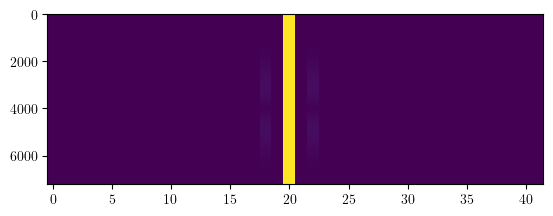

In [9]:
plt.imshow(np.abs(ct),aspect=2e-3, interpolation='nearest')

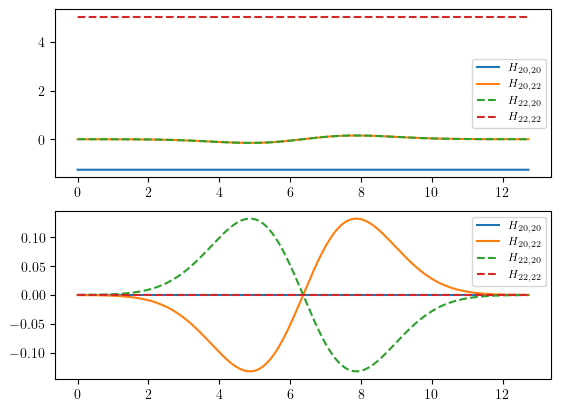

In [10]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

ax = axs[1]
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.legend(fontsize=8)

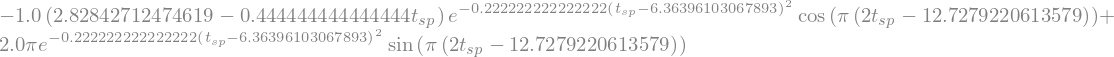

In [11]:
nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hDirac_pulse.Axenv * hDirac_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: par_fix['tau_sp'], mu_sp: par_fix['mu_sp'], A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

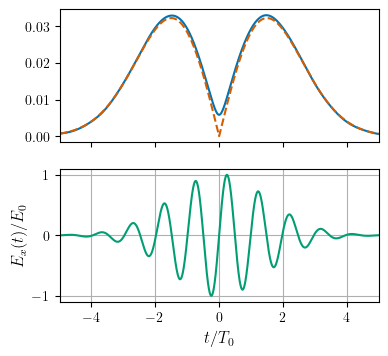

In [12]:
corr = -1.0j*ifs_hamiltonians[:,20,22]/(xis[:,22] - xis[:,20])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,22]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

## Different ky

In [93]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 0.2, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -0.2828, wf (spinor): [-0.707+0.j   0.5  -0.5j]


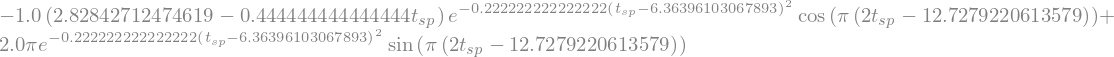

In [94]:
nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hDirac_pulse.Axenv * hDirac_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: par_fix['tau_sp'], mu_sp: par_fix['mu_sp'], A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

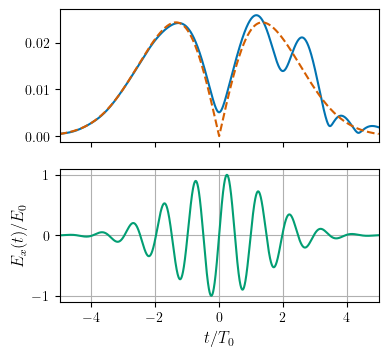

In [96]:
corr = -1.0j*ifs_hamiltonians[:,20,22]/(xis[:,22] - xis[:,20])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,22]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

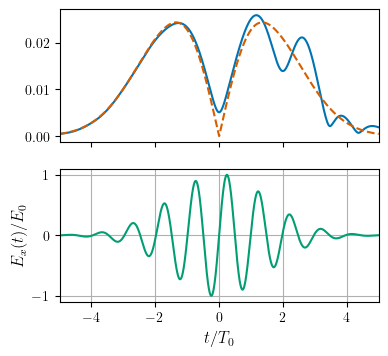

In [ ]:
corr = -1.0j*ifs_hamiltonians[:,30,32]/(xis[:,32] - xis[:,30])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,32]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

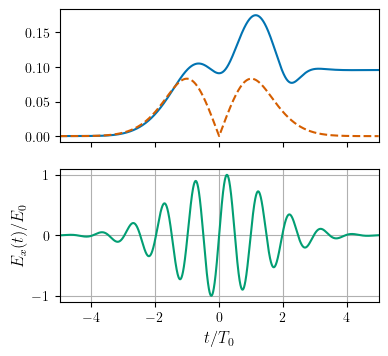

In [92]:
corr = -1.0j*ifs_hamiltonians[:,30,31]/(xis[:,31] - xis[:,30])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,31]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

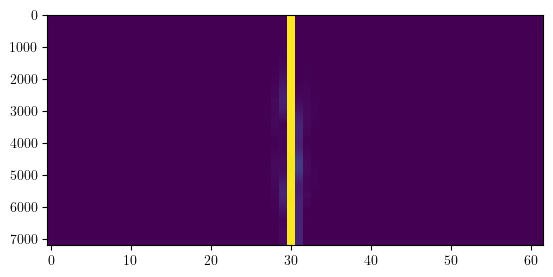

In [78]:
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

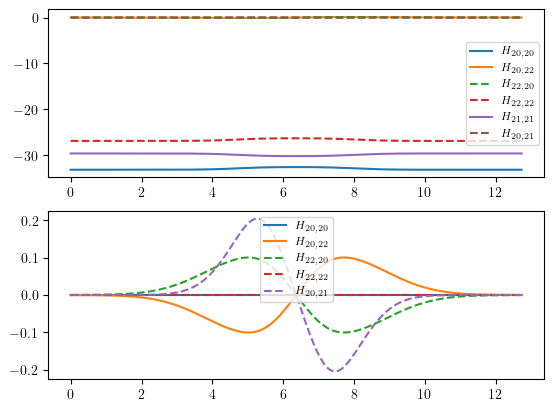

In [87]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,21,21]), '-', label=r'$H_{21,21}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,20,21]), '--', label=r'$H_{20,21}$')
ax.legend(fontsize=8)

ax = axs[1]
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,20]), label=r'$H_{20,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,22]), label=r'$H_{20,22}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,20]), '--', label=r'$H_{22,20}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,22,22]), '--', label=r'$H_{22,22}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,20,21]), '--', label=r'$H_{20,21}$')
ax.legend(fontsize=8)

In [97]:
## Data Figura 3
### For the linear Dirac model we need to calculate this for an arbitrary kx (it is k independent) and the spectrum is also not changing with the amplitude, so just one Ax value is fine
params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts3 = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 1.2, }
solver = (IFS_solver(hDirac_pulse, ts3, params_env, params_ham, Nmax=10))
indexCbase = solver.indexCbase
tagvec  = solver.tag_fqlevels()
ct, psitsol = solver.c_t(psi0band=0, psi_t=True)
ts = ts3[:len(ct)]
ifs_hamiltonians = solver.ChamL

momentax = np.linspace(-2.2, 2.2, 201) 
par = {'k_y': 0., 'A_x': 1e-4, 'A_y': 0.}
eL = np.array([-np.abs(momentax), np.abs(momentax)]).T

State at t = 0.00 energy = -1.2165, wf (spinor): [-0.707+0.j     0.697-0.116j]


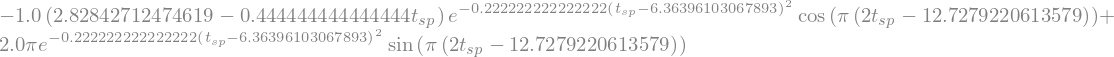

In [100]:
nt,ncs,_ = ifs_hamiltonians.shape
phases = np.zeros((nt,ncs), dtype=np.float64)
xis    = np.zeros_like(phases)
dt = np.diff(ts)[0]
for i in range(len(phases)):
    xis[i,:] = np.real(np.diag(ifs_hamiltonians[i,:,:]))
    if i==0:
        phases[0,:] = np.angle(ct[0,:])
    else:
        phases[i,:] = phases[i-1,:] + dt * xis[i-1,:]
        
axt_full_ex =hDirac_pulse.Axenv * hDirac_pulse.Vxt
axt_full_ex = axt_full_ex.subs({tau_sp: par_fix['tau_sp'], mu_sp: par_fix['mu_sp'], A_x: params_env['A_x'], T_p: 1})
axt_full = sp.lambdify(t_sp, axt_full_ex, 'numpy')
ext_full_ex = sp.diff(-axt_full_ex, t_sp)
ext_full    = sp.lambdify(t_sp, ext_full_ex, 'numpy')
ext_full_ex

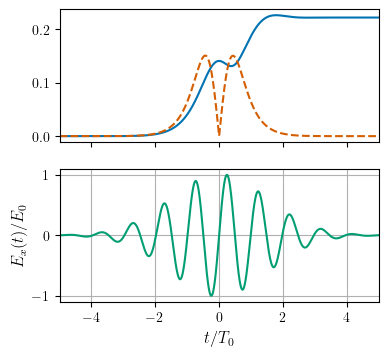

In [108]:
corr = -1.0j*ifs_hamiltonians[:,17,18]/(xis[:,18] - xis[:,17])

fig, axs = plt.subplots(2,1,sharex=True, figsize=set_size(0.65*pagewidth, 0.6*pagewidth))

ax = axs[0]
ax.plot(ts-par_fix["mu_sp"], np.abs(ct[:,17]), color=palette[0])
ax.plot(ts3[:-1]-par_fix["mu_sp"],np.abs(corr), '--', color=palette[2])

ax = axs[1]
ax.plot(ts3-par_fix["mu_sp"],ext_full(ts3)/np.max(ext_full(ts3)), color=palette[1])
ax.grid()
ax.set_xlabel(r'$t/T_0$')
ax.set_ylabel(r'$E_x(t)/E_0$')
ax.set_xlim(-5,5)

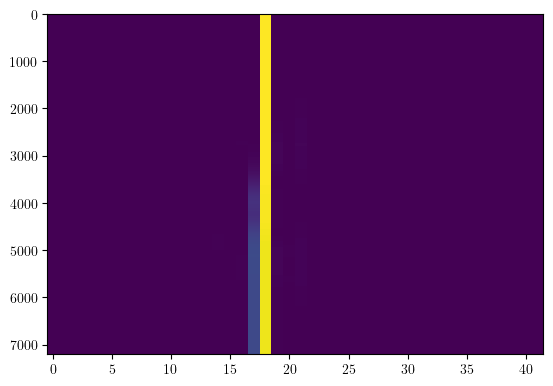

In [102]:
plt.imshow(np.abs(ct),aspect=4e-3, interpolation='nearest')

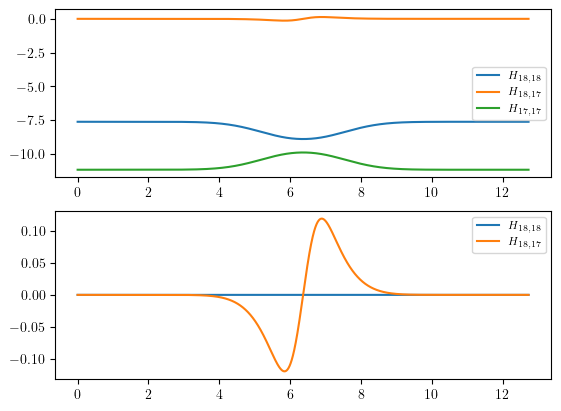

In [119]:
fig, axs = plt.subplots(2,1)

ax = axs[0]
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,18,18]), label=r'$H_{18,18}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,18,17]), label=r'$H_{18,17}$')
ax.plot(ts3[:-1],np.real(ifs_hamiltonians[:,17,17]), label=r'$H_{17,17}$')
ax.legend(fontsize=8)

ax = axs[1]
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,18,18]), label=r'$H_{18,18}$')
ax.plot(ts3[:-1],np.imag(ifs_hamiltonians[:,18,17]), label=r'$H_{18,17}$')
ax.legend(fontsize=8)

[0.07064811 0.19419836 0.110334  ]
[4.2 6.  8. ]


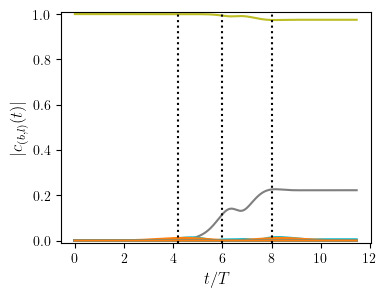

In [120]:
##### Select the three time snapshots
t_sel = np.array([4.2, 6, 8])
inds_t = [np.argmin(np.abs(ts3-ti)) for ti in t_sel]
Axfunct = sp.lambdify(t_sp, (hDirac_pulse.Axenv).evalf(subs={hDirac_pulse.ham_dict[key]:val for key, val in params_env.items()}))
Alist = Axfunct(t_sel)
fig, ax = plt.subplots(1, 1, figsize = (4,3))
plt.plot(ts3[:len(ct)], np.abs(ct))
[plt.axvline(i, color ='k', ls =':') for i in t_sel]
ax.set(xlabel = r'$t/T$', ylim = (-0.01, 1.01))
ax.set(ylabel = r'$|c_{(b,l)}(t)|$')
print(Alist/5) 
print(t_sel)

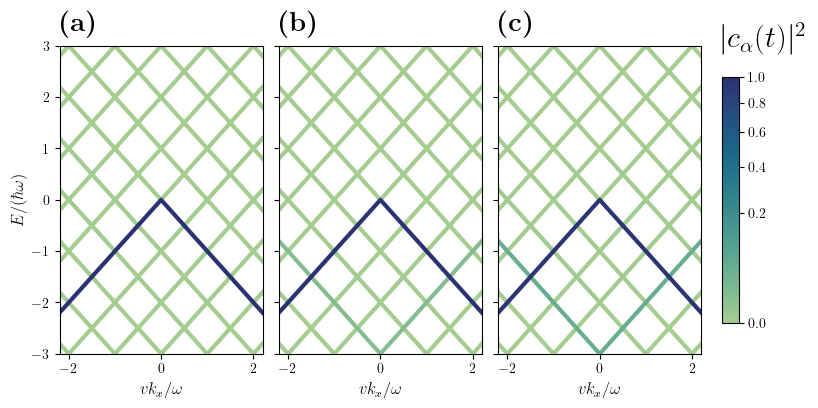

In [ ]:
## Figure 3
cmap =  sns.color_palette("crest", as_cmap=True)
norm = mpl.colors.PowerNorm(vmin = 0, vmax = 1, gamma = 0.5)

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

for ti, ax in zip(inds_t, axs):
    for cti, i  in enumerate(indexCbase):
        l, m = tagvec[i]
        z1 = ax.plot(momentax, eL[:,int(l)%2] + m, 
                     c = cmap(norm(np.abs(ct[ti, cti])**2)), 
                     zorder = np.abs(ct[ti, cti]), lw = 3)
        z1 = ax.scatter(-10, -10, 
                     c = (np.abs(ct[ti, cti])**2), cmap = cmap, norm = norm)
    ax.set(xlabel=(r'$vk_x/\omega$'))
axs[0].set(ylabel = r'$E/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
cbar_ax = fig.colorbar(z1, ax=axs, pad=0.03, shrink=0.8, aspect=15, fraction=0.05)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
# fig.savefig(folder0+'/FigsPaper/Spectrum_DiracLin_cs.pdf', bbox_inches='tight')

# Snapshots

In [10]:
## Define the Floquet t-t' Hamiltonian
ham_symbols = sp.symbols("v mu_sp tau_sp", real=True)
ham_dict = {str(b): b for b in ham_symbols}
locals().update( ham_dict)

T = 1
st_dev = np.sqrt(2) * 1.5

par_fix = {'v':1., 'T_p' : 1.,'mu_sp': 3*st_dev, 'tau_sp': st_dev, }
params_env = {'A_x': None, 'A_y':0, 'A_z': 0}
params_ham = {'k_x' : None, 'k_y' : 0.0,}

hDirac_pulse = Hamiltonian_ttp(
    h0_k = v * (k_y * sx - k_x * sy),
    par_var_ham = params_ham,
    par_fix = par_fix,
    Vxt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp)),
    Vyt= sp.cos(2 * sp.pi / T_p * (t_sp-mu_sp) + sp.pi / 2), 
    Axenv = A_x * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2),
    Ayenv = A_y * sp.exp(-((t_sp-mu_sp)/(tau_sp))**2) , 
    ham_symbols=ham_symbols,
    N = 40) ## N is the number of Fourier replicas considered.

params_env = {'A_x': 1.0, 'A_y': 0, 'A_z': 0}
ts = np.linspace(0, 2*par_fix['mu_sp'] * T, 8000) + 1e-6
params_ham = {'k_x': 0.2, 'k_y': 1.0, }

psi0band = 0
ks = np.arange(-2.2, 2.21, 0.05) + 1e-4
calc = True
if calc:
    data = []
    for kx in ks:
        params_ham = {'k_x': kx, 'k_y': 1.0, }
        solver=IFS_solver(hDirac_pulse, ts, params_env, params_ham, Nmax=5)
        ct, psit = solver.c_t(psi0band=psi0band, tend=5.1, psi_t=True)
        data.append({'tagvec':solver.tag_fqlevels(),
                       'indexCbase' : solver.indexCbase,
                       'eL':solver.eL, 'ct':ct, 'psit':psit})
    np.save('fig_DiracLargeky_calphaData', data)
else:
    data = np.load('fig_DiracLargeky_calphaData.npy', allow_pickle=True)

State at t = 0.00 energy = -2.4166, wf (spinor): [-0.707+0.j     0.293+0.644j]
State at t = 0.00 energy = -2.3712, wf (spinor): [-0.707+0.j     0.298+0.641j]
State at t = 0.00 energy = -2.3259, wf (spinor): [-0.707+0.j     0.304+0.638j]
State at t = 0.00 energy = -2.2809, wf (spinor): [-0.707+0.j     0.31 +0.636j]
State at t = 0.00 energy = -2.2361, wf (spinor): [-0.707+0.j     0.316+0.632j]
State at t = 0.00 energy = -2.1914, wf (spinor): [-0.707+0.j     0.323+0.629j]
State at t = 0.00 energy = -2.1471, wf (spinor): [-0.707+0.j     0.329+0.626j]
State at t = 0.00 energy = -2.1030, wf (spinor): [-0.707+0.j     0.336+0.622j]
State at t = 0.00 energy = -2.0591, wf (spinor): [-0.707+0.j     0.343+0.618j]
State at t = 0.00 energy = -2.0155, wf (spinor): [-0.707+0.j     0.351+0.614j]
State at t = 0.00 energy = -1.9723, wf (spinor): [-0.707+0.j     0.359+0.609j]
State at t = 0.00 energy = -1.9294, wf (spinor): [-0.707+0.j     0.366+0.605j]
State at t = 0.00 energy = -1.8868, wf (spinor): [-0

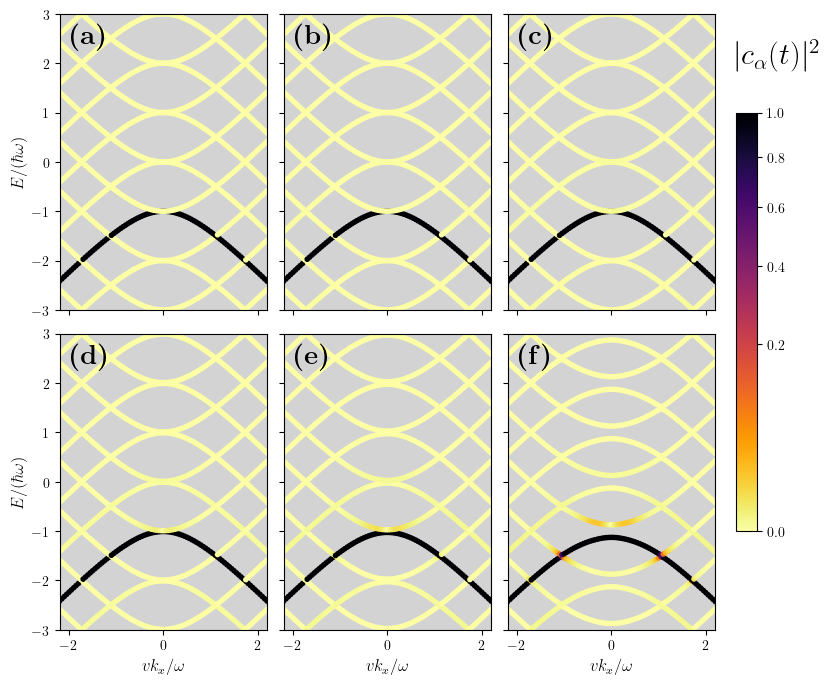

In [12]:
## Figure 6 appendix extra pannels

t_sel = np.array([-1, -0.5, 0, 0.5, 1., 2.])+3
inds_t = [np.argmin(np.abs(ts-ti)) for ti in t_sel]

cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin=0, vmax=1, gamma=0.5)

fig, axs = plt.subplots(2, 3, figsize=(3 * 3, 8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

for ti, ax in zip(inds_t, axs.ravel()):
    eL = np.array([datai['eL'][ti] for datai in data])
    ct_k = np.array([datai['ct'] for datai in data])
    indexCbase_k = np.array([datai['indexCbase'] for datai in data])
    col_k = np.abs(ct_k[:,ti]) ** 2
    ensL = np.array([eL[ki, indexCbase_k[ki]] for ki in range(len(ks))])
    for nband in range(len(indexCbase_k[0])):
        z1 = ax.scatter(ks, ensL[:,nband],
                        c=col_k[:,nband], s=9,
                        cmap=cmap, norm=norm, zorder = nband-100)
    ax.set(facecolor='lightgrey')
[ax.set(ylabel=r'$E/(\hbar \omega)$', ylim=(-3, 3), xlim=(-2.2, 2.2)) for ax in axs[:,0]]
[ax.set(xlabel=(r'$vk_x/\omega$')) for ax in axs[1]]
cbar_ax = fig.colorbar(cm.ScalarMappable(cmap=cmap,  norm = norm), 
                       ax=axs, pad=0.03, shrink=0.95, aspect=20, fraction=0.03,)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.15, pad=-10, loc='left')
createletters(axs.ravel(), coord=[0.05, 0.9])

# fig.savefig(folder0+'/FigsPaper/Spectrum_DiracCirc_cs_6panels.pdf', bbox_inches='tight')

[0.10539922 0.69767633 1.        ]
[-1.2  -0.48  0.  ]


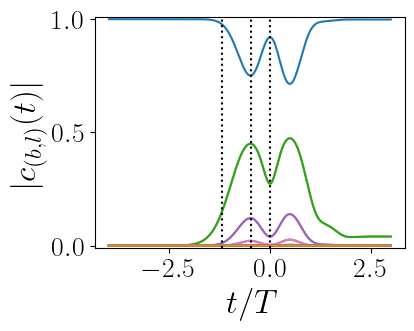

In [ ]:
##### Select the three time snapshots
t_sel = np.array([2.8, 3.52, 4])
inds_t = [np.argmin(np.abs(ts3-ti)) for ti in t_sel]
Axfunct = sp.lambdify(t_sp, (hDirac_pulse.Axenv).evalf(subs={hDirac_pulse.ham_dict[key]:val for key, val in params_env.items()}))
Alist = Axfunct(t_sel)
fig, ax = plt.subplots(1, 1, figsize = (4,3))
plt.plot(ts3[:len(ct)]-4., np.abs(ct))
[plt.axvline(i-4, color ='k', ls =':') for i in t_sel]
ax.set(xlabel = r'$t/T$', ylim = (-0.01, 1.01))
ax.set(ylabel = r'$|c_{(b,l)}(t)|$')
print(Alist/5) 
print(t_sel-4.)

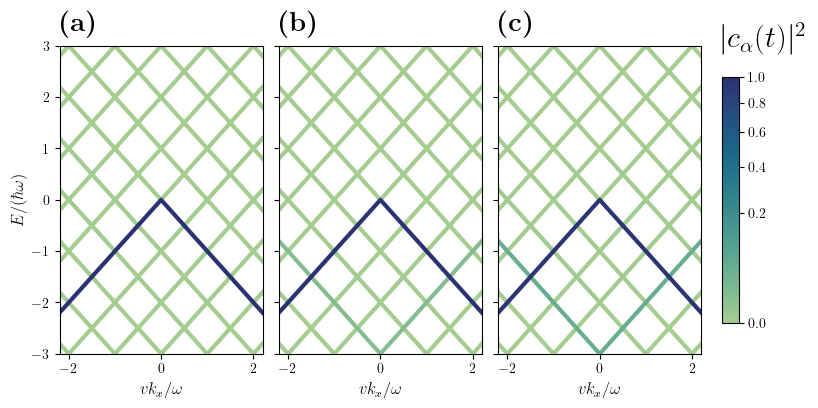

In [118]:
## Figure 3
cmap =  sns.color_palette("crest", as_cmap=True)
norm = mpl.colors.PowerNorm(vmin = 0, vmax = 1, gamma = 0.5)

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

for ti, ax in zip(inds_t, axs):
    for cti, i  in enumerate(indexCbase):
        l, m = tagvec[i]
        z1 = ax.plot(momentax, eL[:,int(l)%2] + m, 
                     c = cmap(norm(np.abs(ct[ti, cti])**2)), 
                     zorder = np.abs(ct[ti, cti]), lw = 3)
        z1 = ax.scatter(-10, -10, 
                     c = (np.abs(ct[ti, cti])**2), cmap = cmap, norm = norm)
    ax.set(xlabel=(r'$vk_x/\omega$'))
axs[0].set(ylabel = r'$E/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
cbar_ax = fig.colorbar(z1, ax=axs, pad=0.03, shrink=0.8, aspect=15, fraction=0.05)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
# fig.savefig(folder0+'/FigsPaper/Spectrum_DiracLin_cs.pdf', bbox_inches='tight')

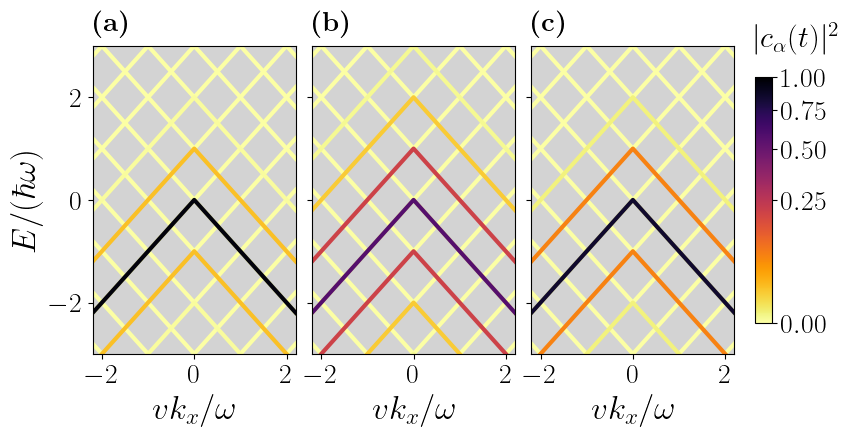

In [14]:
## Figure 3
cmap = mpl.colormaps['inferno_r']
norm = mpl.colors.PowerNorm(vmin = 0, vmax = 1, gamma = 0.5)

fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)

for ti, ax in zip(inds_t, axs):
    for cti, i  in enumerate(indexCbase):
        l, m = tagvec[i]
        z1 = ax.plot(momentax, eL[:,int(l)%2] + m, 
                     c = cmap(norm(np.abs(ct[ti, cti])**2)), 
                     zorder = np.abs(ct[ti, cti]), lw = 3)
        z1 = ax.scatter(-10, -10, 
                     c = (np.abs(ct[ti, cti])**2), cmap = cmap, norm = norm)
    ax.set(facecolor='lightgrey', xlabel=(r'$vk_x/\omega$'))
axs[0].set(ylabel = r'$E/(\hbar \omega)$', ylim = (-3,3), xlim = (-2.2, 2.2))
cbar_ax = fig.colorbar(z1, ax=axs, pad=0.03, shrink=0.8, aspect=15, fraction=0.05)
cbar_ax.ax.set_title(r'$|c_\alpha(t)|^2$', fontsize=22, y=1.2, pad=-14, loc = 'left')
createletters(axs, coord = [0, 1.05])
fig.savefig(folder0+'/FigsPaper/Spectrum_DiracLin_cs.pdf', bbox_inches='tight')